# Discrete version of McCall and three-period optimization

## Andres Perez (worked with group)
(5/5)

## Question 1
Solve a discrete versions of McCall's model.  There are three job offers $70,000, $85,000, and $75,000. Unemployment insurance is worth $30,000, and the discount factor is $\beta=0.9$. In the base case, the wage offers are independent of the state, and the transition matrix is given by:

$$\begin{bmatrix}
1/3, 1/3, 1/3\\
1/3, 1/3, 1/3\\
1/3, 1/3, 1/3
\end{bmatrix}$$

In a second case, the transition matrix is:

$$\begin{bmatrix}
0.8, 0.2, 0.0\\
0.5, 0.5, 0.0\\
0.0, 0.7, 0.3
\end{bmatrix}$$

What is a realistic interpretation of the second case?

In [103]:
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import quantecon as qe
from scipy.optimize import bisect
import scipy as sp
import scipy.optimize as opt

In [104]:
States = ['Low', 'Medium', 'High']
Controls = ['Do not take','Take']
r = np.array([[30000,70000],[30000,85000],[30000,100000]])
M0 = np.array([[1/3,1/3,1/3],[1/3,1/3,1/3],[1/3,1/3,1/3]])
M1 = np.identity(3)
transition = {'Do not take': M0, 'Take': M1}
β=0.9

In [105]:
class DP_Markov():

    """
    
    This class solves a dynamic program whose transition rule can be described 
    by a list of Markov matrices, one for each element of the control set U.
    The Bellman equation is:

           V(x_t) = max_{u_t \in U} (r(x_t,u_t) + β EV(x_{t+1}|(x_t,u_t)))
    
    and the transition rule is a Markov matrix 
    
            M(u)
            
    that depends upon the control u \in U

    Parameters
    ----------
    β : scalar
        the discount factor must be in [0,1)
    max_iter : int
        Maximum number of iterations for the value function solution
    ϵ : scalar
        Convergence parameter.
    X: list
        Names of the states
    U: list
        Names of the controls
    r: array
        function giving reward in state, control
    g: dictionary
        One Markov matrix for each control

    """
 
    def __init__(self, 
                 β=0.9, 
                 max_iter=10_000, 
                 ϵ=10e-5, 
                 X = ['70,000', '85,000', '100,000'], 
                 U = ['Reject','Accept'],
                 r=np.array([[30000,70000],[30000,85000],[30000,100000]]),
                 g = {'Reject':np.identity(3), 'Accept':np.identity(3)}):
        
        self.β=β
        self.max_iter=max_iter
        self.ϵ=ϵ
        self.X=X
        self.U=U
        self.r=r
        self.g=g
    

    def check(self):
        """
        The value function has n elements
        The control set has m elements
        The reward function is an n x m matrix
        The transition is a list of m Markov matrices, each with dimesnion n x n
        The discount factor must satisfy 0 <= beta < 1
        """
        n=len(self.X)
        m=len(self.U)
        if np.array(self.r).shape != (n,m): print("The reward function is not well defined.") 
        if len(self.g) != m: 
            print("There is not the requisite number of transition matrices.")
        if not all(self.g[control].shape == (n,n) for control in self.U):
            print("At least one of the Markov transitions is of the wrong dimension.")
        if not all(np.ones(n)@self.g[control]@np.ones(n) == n for control in self.U):
            print("Give me a break! One of the transition matrices is not Markov.")
        if not all((self.g[control]>=0).all() and (transition[control]<=1).all() for control in self.U):
            print("Give me a break! The elements of the transition matrices are not probabilities.")   
        if beta < 0  or beta >= 1:
            print("Something is wrong with the discount factor.")
        
        return print("I have completed the required checks.")



    def summary(self):
        print('Summary\n' + '-' * 50)
        print(f'The discount factor is: {self.β}')
        print(f'The set of states is: {self.X}')
        print(f'The set of controls is: {self.U}')
        print(f'The reward function is: {self.r}')
        print(f'The transition rule is: {self.g}')


    def _next_state_probs(self,x,u):
        """
        This function takes the state set, the control set, and the list of transition matrices
        It returns the relevant row of the transition matrix in state x, when control u is chosen.
    
        """
        return self.g[u][self.X.index(x)]
              
    def _next_value(self,value):
        """
        This function iterates on the value function using the Bellman equation.
    
        """
        v_next=[]
        for state in self.X:
            bellman=[]
            for control in self.U:
                probs=self._next_state_probs(state,control) 
                #self._next... because I need to call another function within the class
                bellman.append(self.r[self.X.index(state),self.U.index(control)]
                +self.β*(value@probs))
            v_next.append(max(bellman))
            
        return v_next

    
    def solve(self):
        """
        Solves by repeated iteration on the value function.
        
        """
        value=np.zeros(len(self.X)) #start with zero value function
        check=1.0 #check for convergence
        iter=0 #count iterations
        while check > self.ϵ:
            v1 = np.array(self._next_value(value))
            check=max(abs(value-v1))
            value = v1 #reset the value function
            iter += 1 #advance the counter
            if(iter > self.max_iter): #get out of Dodge, if we are in an infinite loop
                print("Algorithm did not converge")
                break
        return value 
    
    def policy(self,value):
        """
        
        Given the value function, one can compute the optimal policy.
        
        """
        policy=[]
        for state in States:
            z=[]
            for control in Controls:
                probs=self._next_state_probs(state,control)
                z.append(self.r[self.X.index(state),self.U.index(control)]
                +beta*(value@probs))
            policy.append(Controls[z.index(max(z))])
        return policy
    
    def ergodic(self,policy):
        """
        
        Given the policy, we can compute the ergodic distribution of states
        
        """
        P=np.empty_like(self.g[self.U[0]])
        for state in self.X:
            i=self.X.index(state)
            P[i,:]=self.g[policy[i]][i,:]
        from quantecon import MarkovChain
        mc = qe.MarkovChain(P)
        p_stationary=mc.stationary_distributions  # Show all stationary distributions
        return p_stationary
    
    def answer(self):
        answer=pd.DataFrame(self.r, self.X, self.U)
        value=self.solve()
        answer['Value function']=np.around(value,2)
        policy=self.policy(value)
        answer['Optimal policy'] = policy
        p_stationary = self.ergodic(policy)
        if len(p_stationary) > 1: 
            print("There are multiple invariant distributions.")
        else:
            answer['Ergodic distribution'] = p_stationary[0]
        
        print(answer)
        return

In [106]:
betsy = DP_Markov(X=States, U=Controls, r=reward, g=transition).answer()

There are multiple invariant distributions.
        Do not take    Take  Value function Optimal policy
Low           30000   70000       835714.28    Do not take
Medium        30000   85000       850000.00           Take
High          30000  100000      1000000.00           Take


## Independent Case

In [107]:
States = ['Low', 'Medium', 'High']
Controls = ['Do not take','Take']
r = np.array([[30000,70000],[30000,85000],[30000,100000]])
M2 = np.array([[0.8,0.2,0.0],[0.5,0.5,0.0],[0.0,0.7,0.3]])
M1 = np.identity(3)
transition = {'Do not take': M2, 'Take': M1}
β=0.9

In [108]:
betsy2 = DP_Markov(X=States, U=Controls, r=reward, g=transition).answer()

There are multiple invariant distributions.
        Do not take    Take  Value function Optimal policy
Low           30000   70000        700000.0           Take
Medium        30000   85000        850000.0           Take
High          30000  100000       1000000.0           Take


A realistic interpretation for the second, independent, case is that the time in which somebody is born or goes into the labor force has a big influence in their lifetime earnings. So we're basically saying, all else equal, if somebody starts working when the economy is booming then their lifetime earnings will, most likely, be higher than those who started working when the economy was down. 

# Question 2

Extend the professor's code that solves for optimal savings and investment from two periods to three periods.  Show what happens to savings in each period as the agent becomes more patient (larger) , as the agent's savings decision become more responsive to interest rate changes (smaller), and as total factor productivity increases (larger). Nice tables or graphics get full credit.

In [122]:
def prod(k):
    return A*k**alpha  #A is a special A and a is alpha

def time_0(c):
    return prod(k0)-c[0]

def time_1(c):
    k1 = prod(k0)-c[0]
    return prod(k1)-c[1]

def time_2(c):
    k1 = prod(k0)-c[0]
    k2 = prod(k1)-c[1]
    return prod(k2)-c[2]

def utility(c):
    u=0
    T = len(c)
    if Q == 1:
        for i in range(T):
            u += Beta**i * np.log(c[i])
    else:
        for i in range(T):
            u += Beta**i * (c[i]**(1-Q)-1)/(1-Q)
    return u



def objective(c):
    return -utility(c)

def MRS(c):
    T = len(c)
    MRS = []
    if Q == 1:
        for i in range(T):
            MRS.append(Beta**i/c[i])
    else:
        for i in range(T):
            MRS.append(Beta**i * c[i]**(-Q))
    return MRS

def objective(c):
    return -utility(c)                

In [123]:
A = 6
k0 = 2
alpha = 0.33
Beta = 0.9
Q = 0.9

c0 = [1.0,1.0,1.0]
bnds = ([0.1, 200], [0.1, 200], [0.1, 200])

cons = ( {"type": "ineq", "fun" : time_0}, {"type": "ineq", "fun": time_1}, {"type": "eq", "fun": time_2})

u= opt.minimize(objective,c0, bounds = bnds, constraints=cons)   #if I get rid of last import then it says opt is not defined
u

     fun: -5.3669368898747
     jac: array([-0.2183032 , -0.18225431, -0.13588363])
 message: 'Optimization terminated successfully'
    nfev: 66
     nit: 16
    njev: 16
  status: 0
 success: True
       x: array([5.42472303, 5.89694948, 7.26882408])

In [124]:
c = u.x
prices = MRS(c)
prices = prices/prices[0]
print("The present price vector is", np.round(prices,2))
print("Gross interest rates are", np.round([1/prices[1],prices[1]/prices[2]],3))
print("The consumption plan is", np.round(c,2))

The present price vector is [1.   0.83 0.62]
Gross interest rates are [1.198 1.341]
The consumption plan is [5.42 5.9  7.27]


In [128]:
def PS7(A, Beta, Q, k0, alpha):
    
    def prod(k):
        return A*k**alpha  #A is a special A and a is alpha

    def time_0(c):
        return prod(k0)-c[0]

    def time_1(c):
        k1 = prod(k0)-c[0]
        return prod(k1)-c[1]

    def time_2(c):
        k1 = prod(k0)-c[0]
        k2 = prod(k1)-c[1]
        return prod(k2)-c[2]
    
    def utility(c):
        u = 0
        T = len(c)
        if Q == 1:
            for i in range(T):
                u += Beta**i * np.log(c[i])
        else:
            for i in range(T):
                u += Beta**i * (c[i]**(1-Q)-1)/(1-Q)
        return u
    
    def objective(c):
        return -utility(c)
        

    def MRS(c):
        T = len(c)
        MRS =[]
        if Q == 1:
            for i in range(T):
                MRS.append(Beta**i/c[i])
        else:
            for i in range(T):
                MRS.append(Beta**i * c[i]**(-Q))
        return MRS
    
    def objective(c):
        return -utility(c)
    
    c0 = [1.0,1.0,1.0]
    bnds = ([0.1,200], [0.1,200], [0.1,200])
    
    cons = (
    {'type': 'ineq','fun': time_0},
    {'type': 'ineq','fun': time_1},
    {'type': 'eq','fun': time_2}
        )
    
    u = opt.minimize(objective,c0,bounds=bnds,constraints=cons)
    c=u.x
    prices=MRS(c)
    interest_rates = [prices[0]/prices[1],prices[1]/prices[2]]
    
    if u['success']==True:
        return(interest_rates)
    else:
        return("Problem optimizing")

## Implementation 1

In [129]:
A = [5,5.5,6,6.5]
results1 = [PS7(a, Beta = 0.9, Q = 0.9, k0 = 2, alpha = 0.33) for a in A]

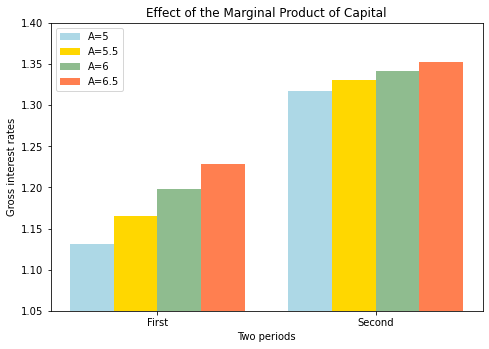

In [155]:
data = results1
X = np.arange(2)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, data[0], color = "lightblue", width = 0.2)
ax.bar(X + 0.20, data[1], color = "gold", width = 0.2)
ax.bar(X + 0.4, data[2], color = "darkseagreen", width = 0.2)
ax.bar(X + 0.6, data[3], color = "coral", width = 0.2)
ax.legend(labels = ["A=5","A=5.5", "A=6", "A=6.5"])
ax.set_xlabel("Two periods")
ax.set_ylabel("Gross interest rates")
ax.set_xticks(np.arange(2)+0.3)
ax.set_xticklabels(("First","Second"))
ax.set_title("Effect of the Marginal Product of Capital")
ax.set_ylim(1.05, 1.4)
plt.show()

## Implementation 2

In [133]:
B = [0.6, 0.7, 0.8, 0.9]
results2 = [PS7(A=6.0, Beta=b, Q=0.9, k0=2, alpha=0.33) for b in B]

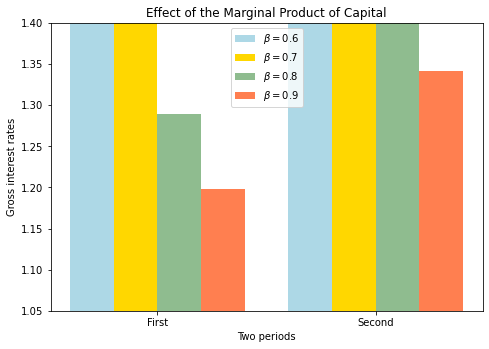

In [154]:
data = results2
X = np.arange(2)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.0, data[0], color = "lightblue", width = 0.2)
ax.bar(X + 0.20, data[1], color = "gold", width = 0.2)
ax.bar(X + 0.4, data[2], color = "darkseagreen", width = 0.2)
ax.bar(X + 0.6, data[3], color = "coral", width = 0.2)
ax.legend(labels = [r"$\beta=0.6$",r"$\beta=0.7$", r"$\beta=0.8$", r"$\beta=0.9$"])
ax.set_xlabel("Two periods")
ax.set_ylabel("Gross interest rates")
ax.set_xticks(np.arange(2)+0.3)
ax.set_xticklabels(("First","Second"))
ax.set_title("Effect of the Marginal Product of Capital")
ax.set_ylim(1.05, 1.4)
plt.show()

## Implementation 3

In [135]:
R = [0.9, 1, 9, 81]
results3 = [PS7(A=6.0, Beta=0.9, Q=r, k0=2, alpha=0.33) for r in R]

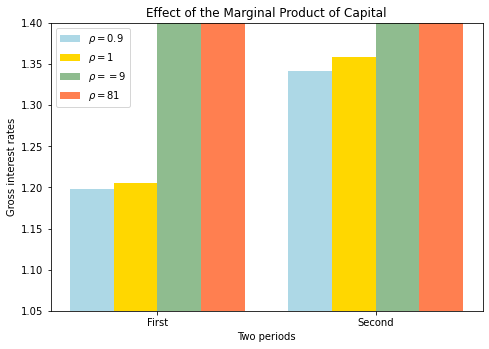

In [153]:
data = results3
X = np.arange(2)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.0, data[0], color = "lightblue", width = 0.2)
ax.bar(X + 0.20, data[1], color = "gold", width = 0.2)
ax.bar(X + 0.4, data[2], color = "darkseagreen", width = 0.2)
ax.bar(X + 0.6, data[3], color = "coral", width = 0.2)
ax.legend(labels = [r"$\rho=0.9$",r"$\rho=1$", r"$\rho==9$", r"$\rho=81$"])
ax.set_xlabel("Two periods")
ax.set_ylabel("Gross interest rates")
ax.set_xticks(np.arange(2)+0.3)
ax.set_xticklabels(("First","Second"))
ax.set_title("Effect of the Marginal Product of Capital")
ax.set_ylim(1.05, 1.4)
plt.show()